In [1]:
import importlib
import os
import re

import numpy as np
import pandas as pd
import tifffile
from pycodex import io
from tqdm import tqdm

# Load the module from the given file path
spec = importlib.util.spec_from_file_location(
    "align",
    "/mnt/nfs/home/wenruiwu/pipeline/pycodex/sift_plot_src_on_dst_coordinate/02_sift_plot_src_on_dst_coordinate.py",
)
align = importlib.util.module_from_spec(spec)
spec.loader.exec_module(align)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/nfs/home/wenruiwu/pipeline/pycodex/sift_plot_src_on_dst_coordinate/02_sift_plot_src_on_dst_coordinate.py'

In [2]:
load_tiff_files = align.load_tiff_files
clean_marker_name = align.clean_marker_name

In [3]:
# Setup logging
io.setup_logging("/mnt/nfs/home/wenruiwu/pipeline/pycodex/sift_plot_src_on_dst_coordinate/output_test.log")
io.setup_gpu("0,1,2,3")

# parameter
excel_parameter = pd.read_excel(
    "/mnt/nfs/home/wenruiwu/pipeline/pycodex/sift_plot_src_on_dst_coordinate/alignment parameter.xlsx",
    sheet_name=None,
)
sheets = [
    "TMA543-formal",
    "TMA544-formal",
    "TMA609 (reg_3x5)-formal",
    "TMA609 (reg_4x5)-formal",
]
df_parameter_alignment = pd.concat([excel_parameter[sheet] for sheet in sheets], axis=0)


Logging is configured. Logs are saved to: /mnt/nfs/home/wenruiwu/pipeline/pycodex/sift_plot_src_on_dst_coordinate/output_test.log and displayed in the console.


In [7]:
marker_file_list = load_tiff_files(df_parameter_alignment["output path of run1-run2 (output_dir)"].iloc[0]).keys()
df_marker = pd.DataFrame([os.path.splitext(marker_file)[0] for marker_file in marker_file_list], columns=["marker"])
df_split = df_marker["marker"].str.split("_", n=3, expand=True)
df_split.columns = ["region", "cycle", "channel", "marker_name"]

df_split

,region,cycle,channel,marker_name
0,reg021,cyc001,ch001,Ch1Cy1
1,reg021,cyc001,ch002,Blank
2,reg021,cyc001,ch003,Blank
3,reg021,cyc001,ch004,Blank
4,reg021,cyc002,ch001,Ch1Cy2
...,...,...,...,...
106,reg001,cyc027,ch001,Ch1Cy31
107,reg001,cyc027,ch004,PDL1_50_250ms
108,reg001,cyc028,ch001,Ch1Cy28
109,reg001,cyc028,ch003,Blank


In [8]:
df_size = pd.DataFrame(df_split.groupby(["region", "cycle", "channel"]).apply(lambda x: x["marker_name"].unique().size)).reset_index()
df_size.rename(columns={0: "count"}, inplace=True)
df_size["count"].value_counts()

1    111
Name: count, dtype: int64

In [9]:
# Pivot the DataFrame
pivoted_df = df_split.pivot_table(
    index=["region", "cycle"],  # Rows (multi-index)
    columns="channel",  # Columns of the pivot table
    values="marker_name",  # Values to fill the table
    aggfunc=",".join,  # Handle cases with duplicates (optional)
)
pivoted_df = pivoted_df.fillna("")

# Reset column names for clarity (optional)
pivoted_df.columns.name = None
pivoted_df.reset_index(inplace=True)

pivoted_df


,region,cycle,ch001,ch002,ch003,ch004
0,reg001,cyc001,Ch1Cy1,,Blank,Blank
1,reg001,cyc002,Ch1Cy2,,,BLANK_500ms_1
2,reg001,cyc003,Ch1Cy3,,IFN-y,DIG_TREM2
3,reg001,cyc004,Ch1Cy4,,TCF1_7,CD45RO
4,reg001,cyc005,Ch1Cy5,,CD16,Tox_Tox2
5,reg001,cyc006,Ch1Cy6,,CD69,PD-1
6,reg001,cyc007,Ch1Cy7,,CD86,P53
7,reg001,cyc008,Ch1Cy8,,CD4,CD8
8,reg001,cyc009,Ch1Cy9,,CD57,CD56
9,reg001,cyc010,Ch1Cy10,,Tim-3,CD28


In [10]:
def export_marker_metadata_to_excel(dir_region: str, dir_output: str):
    """
    Exports marker metadata to an Excel file with multiple sheets.

    This function processes metadata for a given region directory, organizes the marker information,
    and writes the data into an Excel file. Each run's metadata is saved as a separate sheet, and a
    summary sheet for marker order is included.

    Parameters
    ----------
    dir_region : str
        The path to the region directory containing marker metadata for processing.
    dir_output : str
        The path to the output directory where the Excel file will be saved.

    Returns
    -------
    None
        The function saves an Excel file with multiple sheets to the specified output directory.

    Notes
    -----
    - Each sheet corresponds to a run and contains the following columns:
        - `marker`: Marker names.
        - `is_blank`: Boolean flag indicating whether the marker is a blank.
        - `is_dapi`: Boolean flag indicating whether the marker is a DAPI marker.
        - `is_marker`: Boolean flag indicating whether the marker is a valid marker (not blank or DAPI).
        - `is_kept`: An empty column for user-defined marker retention.
    - The `marker_order` sheet contains column headers for each run for user-defined marker order.
    """
    os.makedirs(dir_output, exist_ok=True)

    region_id = os.path.basename(dir_region)
    path_excel = os.path.join(dir_output, f"{region_id}.xlsx")
    with pd.ExcelWriter(path_excel) as writer:
        # sheet for marker metadata of each run
        marker_metadata = io.organize_metadata_keyence(dir_region, subfolders=True)
        run_list = sorted(marker_metadata.keys())
        for run in run_list:
            df_marker = marker_metadata[run]
            df_marker = df_marker.drop(columns=["region"])
            # add flag columns
            df_marker["is_blank"] = df_marker["marker"].str.contains("blank", case=False, na=False)
            df_marker["is_dapi"] = df_marker["marker"].str.match(r"Ch\d+Cy\d+", flags=re.IGNORECASE)
            df_marker["is_marker"] = (~df_marker["is_blank"]) & (~df_marker["is_dapi"])
            df_marker["is_kept"] = ""
            # save to Excel with the run name as the sheet name
            df_marker.to_excel(writer, sheet_name=run, index=False)

        # sheet for marker order
        pd.DataFrame(columns=run_list + ["marker_name"]).to_excel(writer, sheet_name="marker_order", index=False)

# formal run

In [11]:
dir_metadata = "/mnt/nfs/home/wenruiwu/projects/bidmc-jiang-rcc/output/data/02_metadata/"
dir_alignment = "/mnt/nfs/home/wenruiwu/projects/bidmc-jiang-rcc/output/data/01_alignment/"


dir_regions = [
    os.path.join(dir_alignment, file)
    for file in os.listdir(dir_alignment)
    if os.path.isdir(os.path.join(dir_alignment, file))
]
for dir_region in tqdm(dir_regions, desc="Exporting marker metadata to Excel"):
    export_marker_metadata_to_excel(dir_region, dir_metadata)

Exporting marker metadata to Excel:   0%|          | 0/75 [00:00<?, ?it/s]

Exporting marker metadata to Excel: 100%|██████████| 75/75 [00:04<00:00, 16.81it/s]


In [12]:
dir_ometiff = "/mnt/nfs/home/wenruiwu/projects/bidmc-jiang-rcc/output/data/03_ometiff/"
os.makedirs(dir_ometiff, exist_ok=True)

for i, row in tqdm(df_parameter_alignment.iterrows(), total=df_parameter_alignment.shape[0], desc="Packing OME-TIFFs"):
    dir_output, marker_dapi = row[["output path of run1-run2 (output_dir)", "marker_dst"]]

    tma = re.search(r"(TMA\d{3})", dir_output).group(0)
    tag = os.path.basename(dir_output).replace("-", "=")
    id = f"{tma}_{tag}"

    df_marker_dict = pd.read_excel(os.path.join(dir_metadata, f"{id}.xlsx"), sheet_name=None)
    # df_marker_order = df_marker_dict["marker_order"]
    df_marker_order = pd.read_excel(
        "/mnt/nfs/home/wenruiwu/pipeline/pycodex/sift_plot_src_on_dst_coordinate/parameter_ometiff.xlsx",
        sheet_name="marker_order",
    )

    marker_names = []
    marker_paths = []
    for i, row in df_marker_order.iterrows():
        run_list = row.drop("marker_name")
        run = run_list.keys()[~run_list.isna()].item()
        marker_names.append(row["marker_name"])
        marker_paths.append(df_marker_dict[run]["path"][df_marker_dict[run]["marker"] == row[run]].item())

    path_dapi = df_marker_dict["run1"]["path"][
        df_marker_dict["run1"]["marker"] == os.path.splitext(marker_dapi)[0].split("_", 3)[3]
    ].item()
    marker_names = ["DAPI"] + marker_names
    marker_paths = [path_dapi] + marker_paths

    path_ometiff = os.path.join(dir_ometiff, f"{id}.ome.tiff")
    marker_images = [tifffile.imread(path) for path in marker_paths]
    marker_images_stack = np.stack(marker_images, axis=0).astype(np.uint16)
    tifffile.imwrite(
        path_ometiff,
        marker_images_stack,
        metadata={"axes": "CYX", "Channel": {"Name": marker_names}},
        ome=True,
)


Packing OME-TIFFs:   0%|          | 0/75 [00:04<?, ?it/s]


KeyboardInterrupt: 

# DAPI

In [13]:
for i, row in tqdm(df_parameter_alignment.iterrows(), total=df_parameter_alignment.shape[0], desc="Packing OME-TIFFs"):
    dir_output, marker_dapi = row[["output path of run1-run2 (output_dir)", "marker_dst"]]

    tma = re.search(r"(TMA\d{3})", dir_output).group(0)
    tag = os.path.basename(dir_output).replace("-", "=")
    id = f"{tma}_{tag}"

    df_marker_dict = pd.read_excel(os.path.join(dir_metadata, f"{id}.xlsx"), sheet_name=None)
    # df_marker_order = df_marker_dict["marker_order"]
    df_marker_order = pd.read_excel(
        "/mnt/nfs/home/wenruiwu/pipeline/pycodex/sift_plot_src_on_dst_coordinate/parameter_ometiff.xlsx",
        sheet_name="marker_order",
    )

    marker_names = []
    marker_paths = []
    for i, row in df_marker_order.iterrows():
        run_list = row.drop("marker_name")
        run = run_list.keys()[~run_list.isna()].item()
        marker_names.append(row["marker_name"])
        marker_paths.append(df_marker_dict[run]["path"][df_marker_dict[run]["marker"] == row[run]].item())

    path_dapi = df_marker_dict["run1"]["path"][
        df_marker_dict["run1"]["marker"] == os.path.splitext(marker_dapi)[0].split("_", 3)[3]
    ].item()
    marker_names = ["DAPI"] + marker_names
    marker_paths = [path_dapi] + marker_paths

    # path_ometiff = os.path.join(dir_ometiff, f"{id}.ome.tiff")
    # marker_images = [tifffile.imread(path) for path in marker_paths]
    # marker_images_stack = np.stack(marker_images, axis=0).astype(np.uint16)
    # tifffile.imwrite(
    #     path_ometiff,
    #     marker_images_stack,
    #     metadata={"axes": "CYX", "Channel": {"Name": marker_names}},
    #     ome=True,
    # )


Packing OME-TIFFs: 100%|██████████| 75/75 [00:04<00:00, 17.72it/s]


In [66]:
dir_ometiff = "/mnt/nfs/home/wenruiwu/projects/bidmc-jiang-rcc/output/data/04_ometiff_dapi/"
os.makedirs(dir_ometiff, exist_ok=True)

for i, row in tqdm(df_parameter_alignment.iterrows(), total=df_parameter_alignment.shape[0], desc="Packing OME-TIFFs (DAPI)"):
    dir_output, marker_dapi = row[["output path of run1-run2 (output_dir)", "marker_dst"]]

    tma = re.search(r"(TMA\d{3})", dir_output).group(0)
    tag = os.path.basename(dir_output).replace("-", "=")
    id = f"{tma}_{tag}"

    df_marker_dict = pd.read_excel(os.path.join(dir_metadata, f"{id}.xlsx"), sheet_name=None)

    dapi_names = []
    dapi_paths = []
    for k, v in df_marker_dict.items():
        if k != "marker_order":
            dapi_path = v["path"][v["is_dapi"]].tolist()
            dapi_paths = dapi_paths + dapi_path
            dapi_names = dapi_names + [f"{k}-{os.path.basename(path)}" for path in dapi_path]

    path_ometiff = os.path.join(dir_ometiff, f"{id}.ome.tiff")
    marker_images = [tifffile.imread(path) for path in dapi_paths]
    marker_images_stack = np.stack(marker_images, axis=0).astype(np.uint16)
    tifffile.imwrite(
        path_ometiff,
        marker_images_stack,
        metadata={"axes": "CYX", "Channel": {"Name": dapi_names}},
        ome=True,
    )


Packing OME-TIFFs (DAPI): 100%|██████████| 75/75 [1:33:31<00:00, 74.82s/it]


# Presentation

In [27]:
im_raw_1 = tifffile.imread(
    "/mnt/nfs/storage/RCC/RCC_formal_CODEX/RCC_TMA543-run1/images/final/reg001/reg001_cyc001_ch001_Ch1Cy1.tif"
)
im_raw_2 = tifffile.imread(
    "/mnt/nfs/storage/RCC/RCC_formal_CODEX/RCC_TMA543-run2/images/final/reg021/reg021_cyc001_ch001_Ch1Cy1.tif"
)
im_raw_2_rot = np.rot90(im_raw_2, 3)
im_alignment = tifffile.imread(
    "/mnt/nfs/home/wenruiwu/projects/bidmc-jiang-rcc/output/data/01_alignment/TMA543_run1=reg001_run2=reg021/run2/reg021_cyc001_ch001_Ch1Cy1.tiff"
)


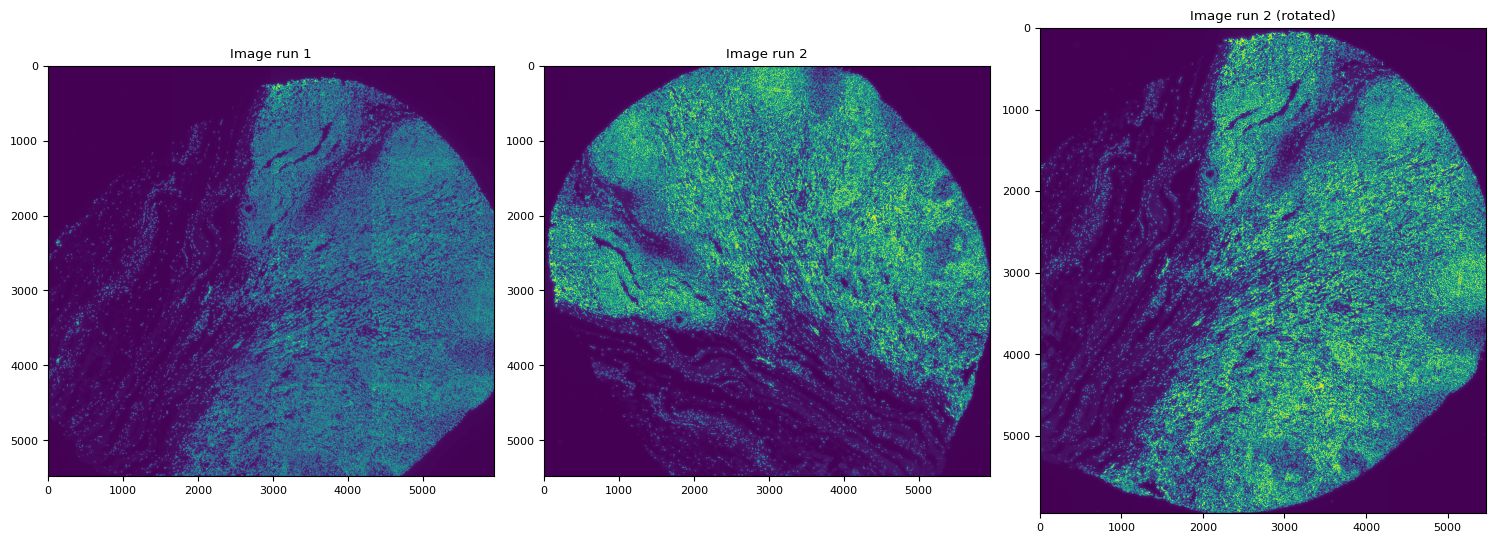

In [31]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 15))
axes = axes.flatten()

axes[0].imshow(im_raw_1)
axes[0].set_title("Image run 1")

axes[1].imshow(im_raw_2)
axes[1].set_title("Image run 2")

axes[2].imshow(im_raw_2_rot)
axes[2].set_title("Image run 2 (rotated)")

plt.tight_layout()


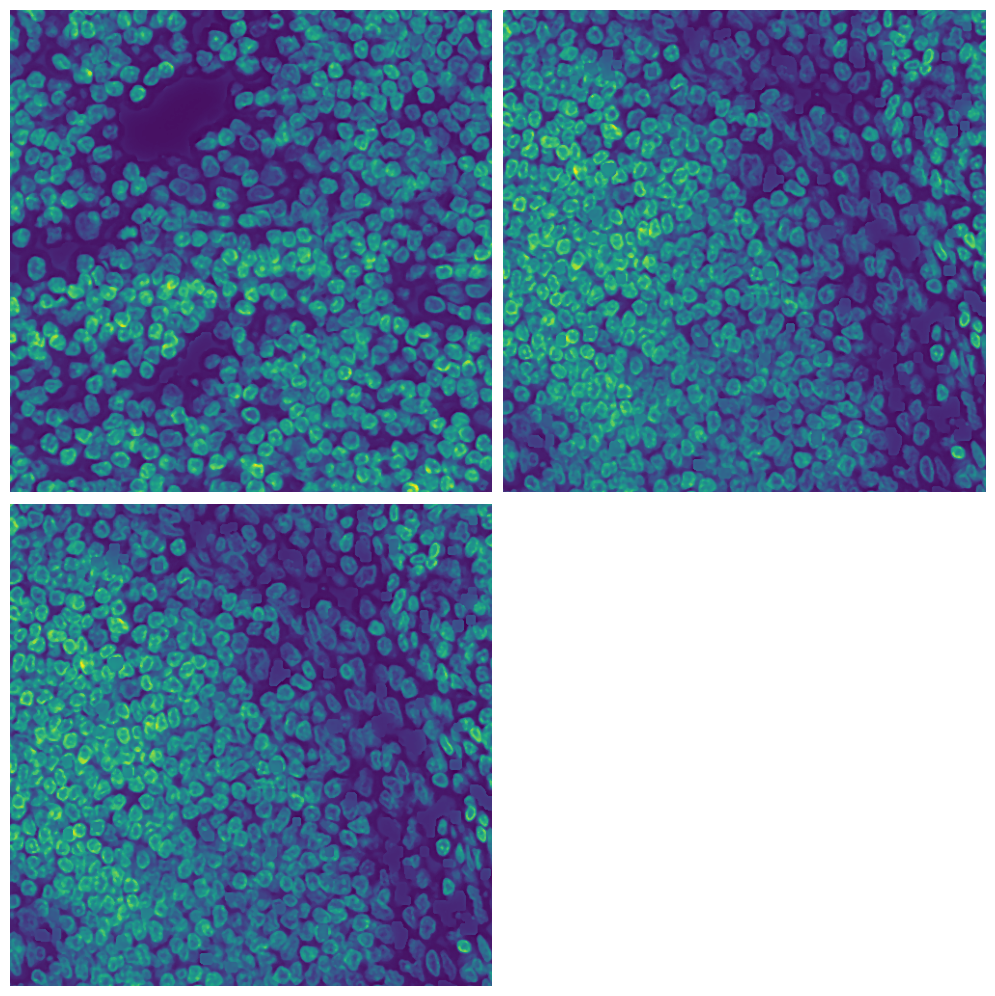

In [16]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

axes[0].imshow(im_raw_1[4000:4500, 3000:3500])
axes[1].imshow(im_raw_2[4000:4500, 3000:3500])
axes[2].imshow(im_raw_2[4000:4500, 3000:3500])

for ax in axes:
    ax.axis("off")

plt.tight_layout()

In [35]:
np.quantile(im_raw_1, [0.01, 0.95])

array([   88., 36729.])

array([    0,     1,     2, ..., 65531, 65532, 65535], dtype=uint16)

In [44]:
np.mean(62.265079498291016 > im_raw_1), np.mean(34155.96484375 > im_raw_1)

(0.005424610332956046, 0.9290035746498302)